# Volatility Forecasting and Custom Loss Function




Credits: Alex Honchar

Source: https://github.com/Rachnog/Deep-Trading/blob/master/volatility/volatility.py


In [1]:
import numpy as np

In [2]:
def shuffle_in_unison(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [3]:
def create_Xt_Yt(X, y, percentage=0.9):
    p = int(len(X) * percentage)
    X_train = X[0:p]
    Y_train = y[0:p]
     
    X_train, Y_train = shuffle_in_unison(X_train, Y_train)
 
    X_test = X[p:]
    Y_test = y[p:]

    return X_train, X_test, Y_train, Y_test

In [4]:
def remove_nan_examples(data):
    newX = []
    for i in range(len(data)):
        if np.isnan(data[i]).any() == False:
            newX.append(data[i])
    return newX

In [5]:
import matplotlib.pylab as plt
import pandas as pd

In [6]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from keras.layers.wrappers import Bidirectional
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import *
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.initializers import *
from keras.constraints import *

from keras import backend as K
import seaborn as sns
sns.despine()

Using TensorFlow backend.


In [7]:
def data2change(data):
    change = pd.DataFrame(data).pct_change()
    change = change.replace([np.inf, -np.inf], np.nan)
    change = change.fillna(0.).values.tolist()
    change = [c[0] for c in change]
    return change

In [8]:
WINDOW = 5
EMB_SIZE = 6
STEP = 1
FORECAST = 1

In [9]:
data_original = pd.read_csv('dataset/700_data_from_IB_1day.csv')[::-1]

In [10]:
openp = data_original.loc[:, 'open'].tolist()
highp = data_original.loc[:, 'high'].tolist()
lowp = data_original.loc[:, 'low'].tolist()
closep = data_original.loc[:, 'close'].tolist()
volumep = data_original.loc[:, 'volume'].tolist()

In [11]:
openp = data2change(openp)
highp = data2change(highp)
lowp = data2change(lowp)
closep = data2change(closep)
volumep = data2change(volumep)

In [12]:
volatility = []
for i in range(WINDOW, len(openp)):
    window = highp[i-WINDOW:i]
    volatility.append(np.std(window))

In [13]:
openp, highp, lowp, closep, volumep = openp[WINDOW:], highp[WINDOW:], lowp[WINDOW:], closep[WINDOW:], volumep[WINDOW:]

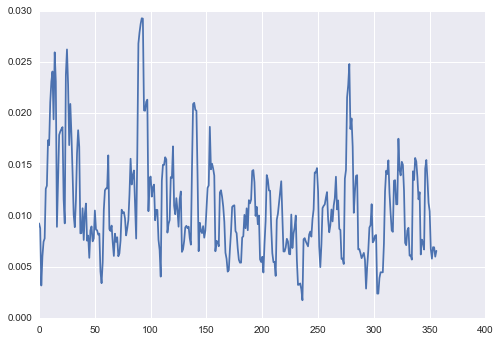

In [27]:
plt.plot(volatility)
plt.show()

In [28]:
X, Y = [], []
for i in range(0, len(data_original), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        volat = volatility[i:i+WINDOW]

        y_i = volatility[i+WINDOW+FORECAST] 
#        y_i = closep[i+WINDOW+FORECAST] 
        x_i = np.column_stack((volat, o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)

In [29]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [30]:
epsilon = 1.0e-9
def qlike_loss(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.log(y_pred) + y_true / y_pred
    return K.mean(loss, axis=-1)

In [31]:
def mse_log(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(K.log(y_true) - K.log(y_pred))
    return K.mean(loss, axis=-1)

In [32]:
def mse_sd(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(y_true - K.sqrt(y_pred))
    return K.mean(loss, axis=-1)  

In [33]:
def hmse(y_true, y_pred):
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    loss = K.square(y_true / y_pred - 1.)
    return K.mean(loss, axis=-1) 

In [34]:
def stock_loss(y_true, y_pred):
    alpha = 100.
    loss = K.switch(K.less(y_true * y_pred, 0), \
        alpha*y_pred**2 - K.sign(y_true)*y_pred + K.abs(y_true), \
        K.abs(y_true - y_pred)
        )
    return K.mean(loss, axis=-1)

In [35]:
model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        filters=16,
                        kernel_size=4,
                        padding='same'))
model.add(MaxPooling1D(2))
model.add(LeakyReLU())
model.add(Convolution1D(filters=32,
                        kernel_size=4,
                        padding='same'))
model.add(MaxPooling1D(2))
model.add(LeakyReLU())
model.add(Flatten())

model.add(Dense(16))
model.add(LeakyReLU())

model.add(Dense(1))
model.add(Activation('linear'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="lolkekr.hdf5", verbose=1, save_best_only=True)

model.compile(optimizer=opt, 
              loss=mse_log)

In [36]:
try:
    history = model.fit(X_train, Y_train, 
              epochs = 100, 
              batch_size = 256, 
              verbose=1, 
              validation_data=(X_test, Y_test),
              callbacks=[reduce_lr, checkpointer],
              shuffle=True)
except Exception as e:
    print (e)



Train on 315 samples, validate on 36 samples
Epoch 1/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 2/100
315/315 [==============================] - 0s - loss: 259.5255 - val_loss: 259.3000
Epoch 3/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 4/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 5/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 6/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 7/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 8/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 9/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 10/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259

315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 41/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 42/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 43/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 44/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 45/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 46/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 47/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 48/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 49/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 50/100
315/315 [=====================

315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 81/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 82/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 83/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 84/100
315/315 [==============================] - 0s - loss: 259.5255 - val_loss: 259.3000
Epoch 85/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 86/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 87/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 88/100
315/315 [==============================] - 0s - loss: 259.5256 - val_loss: 259.3000
Epoch 89/100
315/315 [==============================] - 0s - loss: 259.5255 - val_loss: 259.3000
Epoch 90/100
315/315 [=====================

In [37]:
model.load_weights("lolkekr.hdf5")
pred = model.predict(X_test)
predicted = pred
original = Y_test
    

/Users/hussainmohammadyousuf/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:531: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


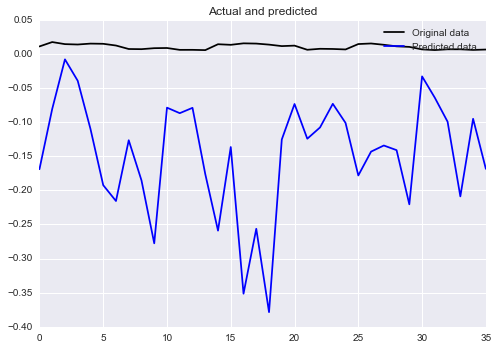

0.0317353187734
0.157586736536
17.0561156597


In [38]:
plt.title('Actual and predicted')
plt.legend(loc='best')
plt.plot(original, color='black', label = 'Original data')
plt.plot(predicted, color='blue', label = 'Predicted data')
plt.legend()
plt.show()
    
print (np.mean(np.square(predicted - original)))
print (np.mean(np.abs(predicted - original)))
print (np.mean(np.abs((original - predicted) / original)))